In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from src.data.data_loader import OpenMLDataLoader
from src.data.dataset_interface import DataInterface
from src.eda.eda import print_basic_info
from src.log_reg_ccd import LogRegCCD
from src.utils import plot_lasso_path, evaluate_model
import src.measures as measure

In [2]:
DATASET_NAME = 'arcene'

In [3]:
data_loader = OpenMLDataLoader(dataset_name=DATASET_NAME, version=1)
data_interface = DataInterface(data_loader=data_loader, dataset_name=DATASET_NAME)
data_interface.preprocess_data()
print_basic_info(data_interface.data)

Removed 39 constant features.
Removed 6547 correlated features.

Dataset shape:
(200, 3414)

Dataset features count:
3414

Dataset observation count:
200

Dataset overview:
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.727582  0.896595 -0.849482 -1.488712 -0.631030  1.205310  0.981283   
1 -0.727582  0.104200  0.305605 -1.036462  1.588952  1.357088  0.843222   
2 -0.727582 -0.978740 -0.835396 -1.844052 -0.631030  0.380015  0.970238   
3 -0.727582  0.500398 -0.229679 -0.325782 -0.113034  0.949184  1.345764   
4  1.431415 -0.978740  1.136705  0.145851 -0.631030 -1.355950  0.567100   

         V8        V9       V10  ...     V9953     V9961     V9967     V9968  \
0  0.828264 -0.841013 -0.733344  ... -0.574610 -0.301383  2.782706  0.656539   
1 -0.517959  0.382717 -0.733344  ...  0.795321 -0.301383 -0.198467  1.742155   
2 -0.517959 -0.841013 -0.733344  ... -0.574610 -0.301383 -0.594567 -0.144749   
3 -0.517959 -0.841013 -0.733344  ... -0.574610 -0.301383

In [4]:
data_interface.split_data()
data = data_interface.get_data()
X_train, y_train = data['train_data'].values, data['train_labels'].values
X_test, y_test = data['test_data'].values, data['test_labels'].values
X_valid, y_valid = data['val_data'].values, data['val_labels'].values

In [5]:
ccd = LogRegCCD(verbose=False)
ccd.fit(X_train, y_train, lam_max=0.5, lam_count=20)
y_pred = ccd.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train accuracy: {accuracy:.4f}")

Train accuracy: 0.4514


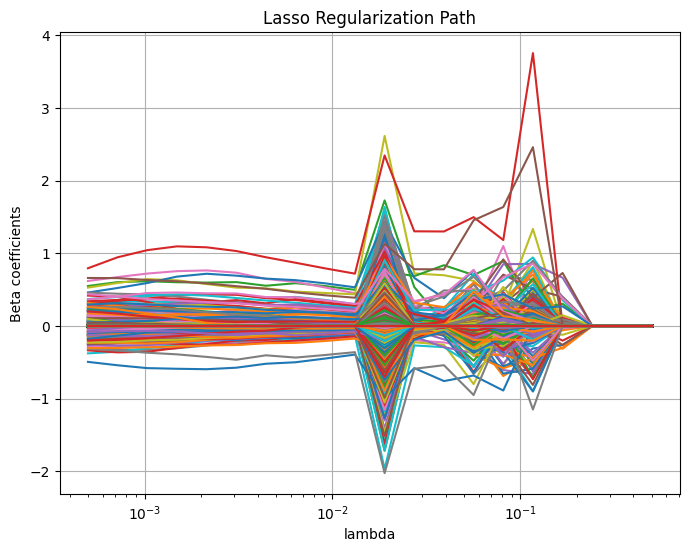

In [6]:
ccd.plot_lasso_path()

In [7]:
print(ccd.best_beta)

[2.28104249 0.         0.         ... 0.         0.         0.        ]


## Validation

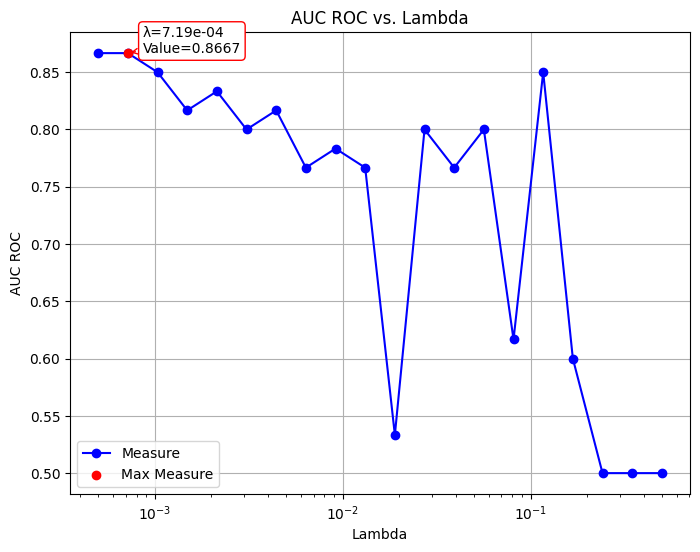

Validation Accuracy: 0.8125
Best Beta: [ 0.89284541 -0.         -0.         ...  0.          0.
 -0.        ]


In [8]:
ccd.plot(X_valid, y_valid, measure=measure.AUCROC())
ccd.validate(X_valid, y_valid, measure=measure.AUCROC())
y_pred = ccd.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Best Beta: {ccd.best_beta}")

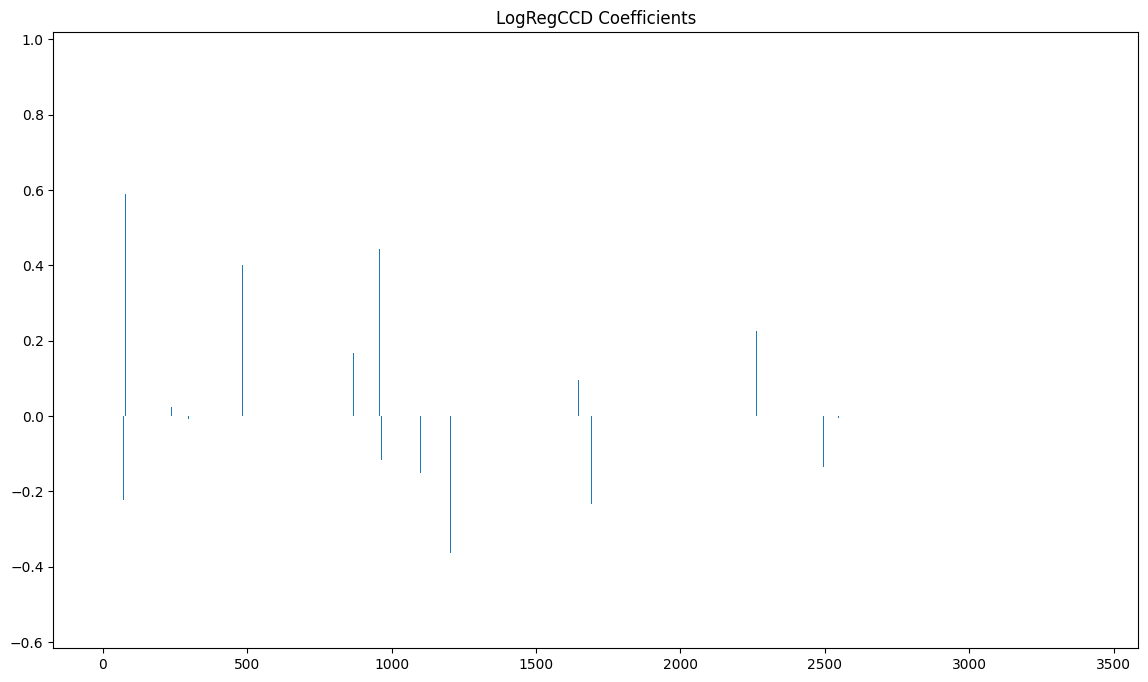

In [9]:
ccd_coefs = ccd.best_beta
n_features = len(ccd_coefs)

indices = np.arange(n_features)
bar_width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(indices + bar_width, ccd_coefs, bar_width)
plt.title('LogRegCCD Coefficients')
plt.show()

In [10]:
ccd_coefs = ccd.best_beta[1:]
top_5_indices = np.argsort(np.abs(ccd_coefs))[-5:]
feature_names = data_interface.get_feature_names()
top_5_features = [(feature_names[i], ccd_coefs[i]) for i in top_5_indices]

top_5_features_df = pd.DataFrame(top_5_features, columns=["Feature", "Coefficient"])

print("Top 5 most important features based on coefficients:")
display(top_5_features_df)

Top 5 most important features based on coefficients:


,Feature,Coefficient
0,V86,0.590352
1,V34,0.602276
2,V4542,0.657377
3,V38,0.671923
4,V764,0.944442


## Comparison with LogisticRegression

In [11]:
lr = LogisticRegression(penalty=None, max_iter=10000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Train Accuracy: 1.0000


In [12]:
print(lr.coef_)

[[ 0.00565455 -0.00755655 -0.01921111 ...  0.02170242  0.02668024
  -0.00041565]]


In [13]:
y_pred = lr.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.6250


In [23]:
ccd_metrics = evaluate_model(ccd, X_test, y_test, "LogRegCCD")
lr_metrics = evaluate_model(lr, X_test, y_test, "LogisticRegression")

print(f"LogRegCCD accuracy: {accuracy_score(y_test, ccd.predict(X_test))}")
print(f"LogisticRegression accuracy: {accuracy_score(y_test, lr.predict(X_test))}")

results = pd.DataFrame({
    'Metric': ['ROC AUC', 'PR AUC', 'F1 Score', 'Balanced Accuracy'],
    'LogRegCCD': [ccd_metrics['ROC AUC'], ccd_metrics['PR AUC'],
                  ccd_metrics['F1 Score'], ccd_metrics['Balanced Accuracy']],
    'LogisticRegression': [lr_metrics['ROC AUC'], lr_metrics['PR AUC'],
                           lr_metrics['F1 Score'], lr_metrics['Balanced Accuracy']]
})

results.to_csv(f'./results/{DATASET_NAME}.csv', index=False)

print("\nPerformance Comparison:")
display(results)

LogRegCCD accuracy: 0.775
LogisticRegression accuracy: 0.675

Performance Comparison:


,Metric,LogRegCCD,LogisticRegression
0,ROC AUC,0.812500,0.841146
1,PR AUC,0.875061,0.881195
2,F1 Score,0.823529,0.648649
3,Balanced Accuracy,0.750000,0.718750


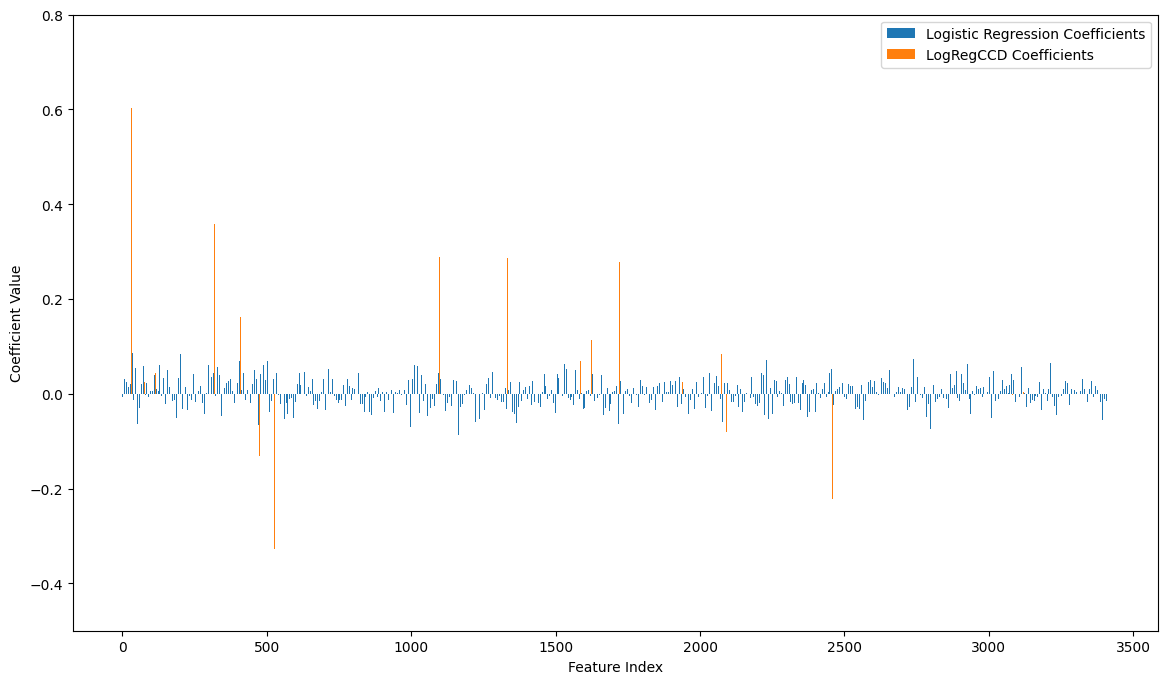

In [28]:
lr_coefs = lr.coef_[0]
ccd_coefs = ccd.best_beta[1:]
n_features = len(lr_coefs)
indices = np.arange(n_features)
bar_width = 0.5

plt.figure(figsize=(14, 8))
plt.bar(indices, lr_coefs, bar_width, label='Logistic Regression Coefficients')
plt.bar(indices + bar_width, ccd_coefs, bar_width, label='LogRegCCD Coefficients')

plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.ylim(-0.5, 0.8)
plt.legend()
plt.savefig('./results/arcene_coefficients.png')
plt.show()

In [30]:
nonzero_elements = np.count_nonzero(ccd_coefs)
total_features = len(ccd_coefs)
reduced_features = total_features - nonzero_elements

print(f"Number of reduced features by regularization: {reduced_features}")

Number of reduced features by regularization: 3259


## Comparisons with library regularizations

In [16]:
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=10)
lr_l1.fit(X_train, y_train)
y_pred = lr_l1.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")

y_pred = lr_l1.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Train Accuracy: 1.0000
Validation Accuracy: 0.8125


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

C_values = 1/ccd.lambdas
best_C = None
best_accuracy = 0

for C in C_values:
    lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    lr_l1.fit(X_train, y_train)
    y_pred = lr_l1.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print(f"Best C: {best_C:.4f}, Best Validation Accuracy: {best_accuracy:.4f}")

Best C: 75.8538, Best Validation Accuracy: 0.8750


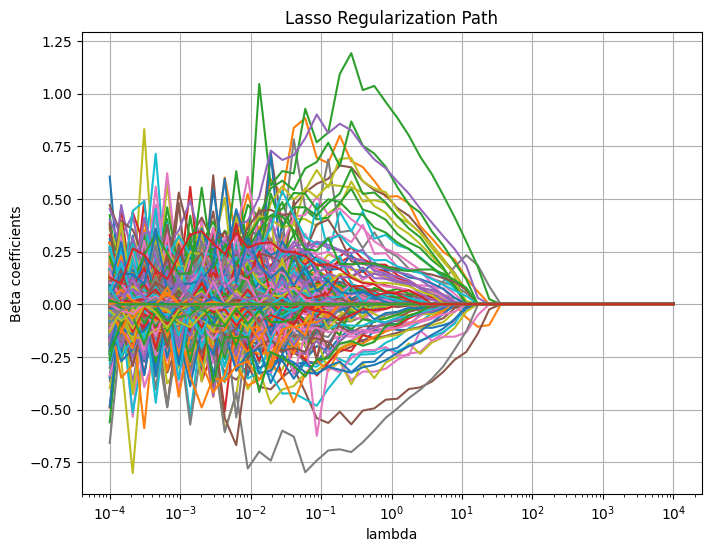

In [18]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

n = data_interface.data.data.shape[0]
lr_cv = LogisticRegressionCV(
    Cs=50,
    cv=10,
    penalty='l1',
    solver='liblinear',
    max_iter=1000
)
lr_cv.fit(X_train, y_train)

alphas_lasso = 1/lr_cv.Cs_
coefs_lasso = lr_cv.coefs_paths_[1][0, :, 1:] # For fold 0 for simplicity
coefs_lasso = coefs_lasso.transpose()
plot_lasso_path(alphas_lasso, coefs_lasso)

In [19]:
def find_biggest_coef(coefs, alphas, alpha_min, alpha_max, type='ccd'):
    mask = (alphas >= alpha_min) & (alphas <= alpha_max)
    if type == 'ccd':
        filtered_coefs = coefs[mask, 1:]
    else:
        filtered_coefs = coefs[:, mask]

    max_coefs = np.max(np.abs(filtered_coefs), axis=1)
    most_important_feature_index = np.argmax(max_coefs)

    return most_important_feature_index, max_coefs[most_important_feature_index]

alpha_min = 10**-2
alpha_max = 10**-1

In [20]:
most_important_feature_index, max_coef = find_biggest_coef(coefs_lasso, alphas_lasso, alpha_min, alpha_max, 'lasso')
most_important_feature_name = feature_names[most_important_feature_index]

print("LogRegCCD:")
print(f"Feature with the biggest coefficient for {alpha_min} < lambda < {alpha_max}: {most_important_feature_name} ({most_important_feature_index})")
print(f"Maximum coefficient value: {max_coef}")

LogRegCCD:
Feature with the biggest coefficient for 0.01 < lambda < 0.1: V763 (452)
Maximum coefficient value: 1.045753848392185


In [21]:
most_important_feature_index, max_coef = find_biggest_coef(ccd.betas, ccd.lambdas, alpha_min, alpha_max)
most_important_feature_name = feature_names[most_important_feature_index]

print("LogRegCCD:")
print(f"Feature with the biggest coefficient for {alpha_min} < lambda < {alpha_max}: {most_important_feature_name} ({most_important_feature_index})")
print(f"Maximum coefficient value: {max_coef}")

LogRegCCD:
Feature with the biggest coefficient for 0.01 < lambda < 0.1: V5 (4)
Maximum coefficient value: 2.6146142400186694
